In [2]:
# Francisco Dominguez Mateos
# 27/06/2020
# Defining a custom activation functions maxtanh and xtanh

In [1]:
import random
import numpy as np
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import utils,losses
from tensorflow.keras.datasets import mnist,fashion_mnist,cifar100,cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Input, Flatten, Dense, Dropout, Lambda, Conv2D,MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adadelta,Adam
from tensorflow.keras.activations import relu,selu,softplus,softsign,tanh,elu,sigmoid
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import cv2

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline
print(tf.__version__)
print(tensorflow.keras.__version__)

2.2.0
2.3.0-tf


In [2]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
def plot_histories(histories):
    plt.figure(figsize=(10,10))
    for k in histories:
        history=histories[k]
        # summarize history for accuracy
        plt.plot(history.history['accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
    plt.legend(histories.keys(), loc='upper left')
    plt.show()
    plt.figure(figsize=(10,10))
    for k in histories:
        history=histories[k]
        # summarize history for accuracy
        plt.plot(history.history['val_accuracy'])
        plt.title('model val_accuracy')
        plt.ylabel('val_accuracy')
        plt.xlabel('epoch')
    plt.legend(histories.keys(), loc='upper left')
    plt.show()
    plt.figure(figsize=(10,10))
    for k in histories:
        history=histories[k]
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
    plt.legend(histories.keys(), loc='upper left')
    plt.show()
    plt.figure(figsize=(10,10))
    for k in histories:
        history=histories[k]
        # summarize history for loss
        plt.plot(history.history['val_loss'])
        plt.title('model val_loss')
        plt.ylabel('val_loss')
        plt.xlabel('epoch')
    plt.legend(histories.keys(), loc='upper left')
    plt.show()

In [3]:
num_classes=100
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#(x_train, y_train), (x_test, y_test) = cifar100.load_data()
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
input_shape = x_train.shape[1:]
if(len(x_train.shape)==3):
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_test  = x_test.reshape (x_test.shape [0], x_test.shape [1], x_test.shape [2], 1)
    input_shape = (x_train.shape[1],x_train.shape[1],1)

y_train = y_train.astype("float32")
y_test  = y_test.astype("float32")
x_train = x_train/255*2.0-1.0
x_test  = x_test /255*2.0-1.0
#input_shape = x_train.shape[1:]
# convert class vectors to binary class matrices
y_train = utils.to_categorical(y_train, num_classes)
y_test  = utils.to_categorical(y_test, num_classes)
print(input_shape)
print(x_train.shape)
print(x_test.shape)

(28, 28, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


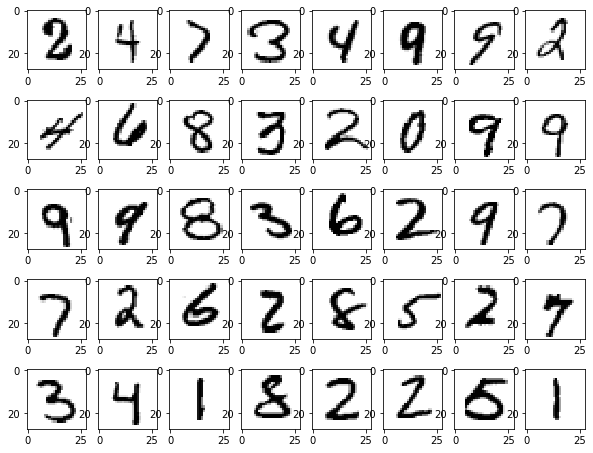

In [4]:
plt.figure(figsize=(10,8))
for i in range(40):
    plt.subplot(5,8,i+1)
    idx=random.randrange(0,x_train.shape[0])
    if(x_train.shape[3]==1):
        plt.imshow(x_train[idx,:,:,0], cmap="gray_r")
    else:
        plt.imshow((x_train[idx,:,:,:]+1)/2)
plt.show()

In [5]:
def build_mmtanh(s=0.6,alpha=0.5):
    def mmtanh(x):
        t=K.tanh(x/s)
        m=K.maximum(t,x*s)
        n=K.minimum(t,x*s)
        mm=K.maximum(m,0)
        mn=K.minimum(n,0)*alpha
        return mm+mn
    return mmtanh
def build_xtanh(s=10,alpha=0.5):
    def xtanh(x):
        t=K.tanh(x)
        r=t+x/s
        return K.maximum(r,r*alpha)
    return xtanh
def swish(x, beta = 1):
    return (x * K.sigmoid(beta * x))
def leakyrelu(x,alpha=0.3):
    m=K.maximum(x,x*alpha)
    return m
def asin(x):
    return K.sin(x)
class Xtanh(Layer):
    def __init__(self, units=32, input_dim=32):
        super(Linear, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(
            initial_value=b_init(shape=(units,), dtype="float32"), trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class Antirectifier(layers.Layer):
    '''This is the combination of a sample-wise
    L2 normalization with the concatenation of the
    positive part of the input with the negative part
    of the input. The result is a tensor of samples that are
    twice as large as the input samples.

    It can be used in place of a ReLU.

    # Input shape
        2D tensor of shape (samples, n)

    # Output shape
        2D tensor of shape (samples, 2*n)

    # Theoretical justification
        When applying ReLU, assuming that the distribution
        of the previous output is approximately centered around 0.,
        you are discarding half of your input. This is inefficient.

        Antirectifier allows to return all-positive outputs like ReLU,
        without discarding any data.

        Tests on MNIST show that Antirectifier allows to train networks
        with twice less parameters yet with comparable
        classification accuracy as an equivalent ReLU-based network.
    '''

    def compute_output_shape(self, input_shape):
        shape = list(input_shape)
        assert len(shape) == 2  # only valid for 2D tensors
        shape[-1] *= 2
        return tuple(shape)

    def call(self, inputs):
        inputs -= K.mean(inputs, axis=1, keepdims=True)
        inputs = K.l2_normalize(inputs, axis=1)
        pos = K.relu(inputs)
        neg = K.relu(-inputs)
        return K.concatenate([pos, neg], axis=1)

In [6]:
def create_base_network(input_shape,activation):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x=input
    for nf in [32,32,32,32,32,32,32,32,32,32]:
        x = Conv2D(nf, 3)(x)
        x = BatchNormalization()(x)
        x = Activation(activation)(x)
        x = Dropout(0.5)(x)
        #x = MaxPooling2D(2)(x)
    x = Flatten()(x)
    for na in [128,64]:
        x = Dense(na)(x)
        x = BatchNormalization()(x)
        x = Activation(activation)(x)
        #x = Dropout(0.5)(x)
    #for 2D view
    x = Dense(  num_classes,activation="softmax")(x)
    return Model(input, x)

In [45]:
activations={}
nets={}
activations["mmtanh"]=build_mmtanh(0.85,0.5)
activations["xtanh"] =xtanh
#activations["asin"] =asin
#activations["relu"]  =relu
activations["swish"] =swish
#activations["leakyrelu"] =leakyrelu
#activations["selu"] =selu
#activations["softplus"] =softplus
#activations["softsign"] =softsign
#activations["tanh"] =tanh
activations["elu"] =elu
#activations["sigmoid"] =sigmoid

for k in activations:
    nets[k]=create_base_network(input_shape,activations[k])
    nets[k].compile(loss=losses.categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])
#nets["relu"].summary()

In [43]:
histories={}    
epochs=10
batch_size=1000
for k in activations:
    print("********************************* Training ",k)
    histories[k]=nets[k].fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

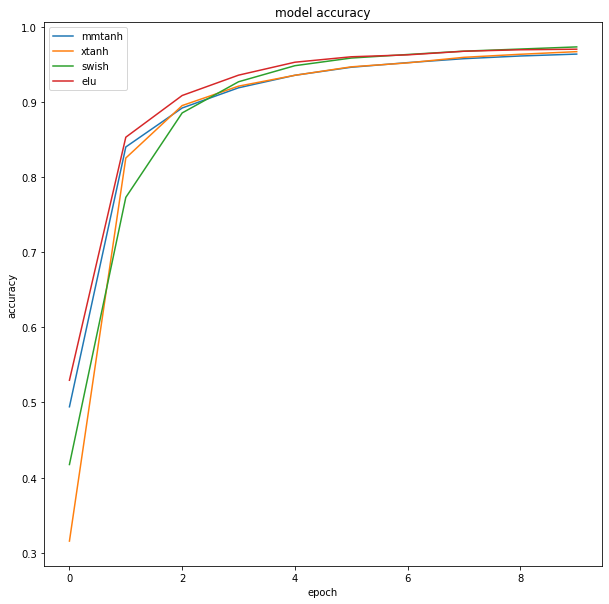

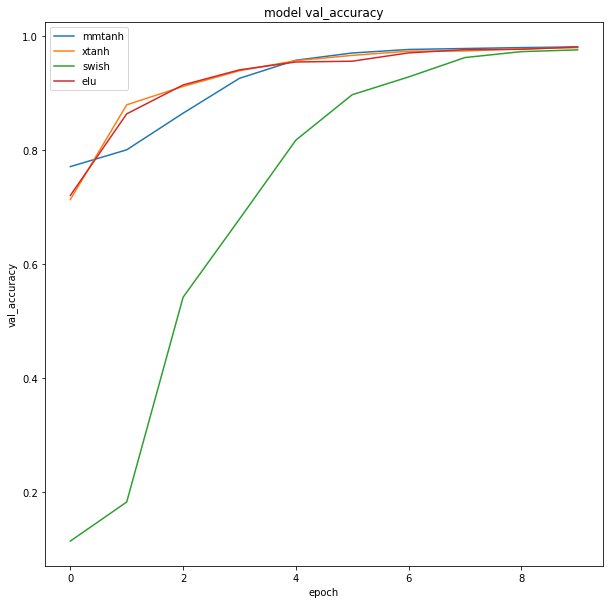

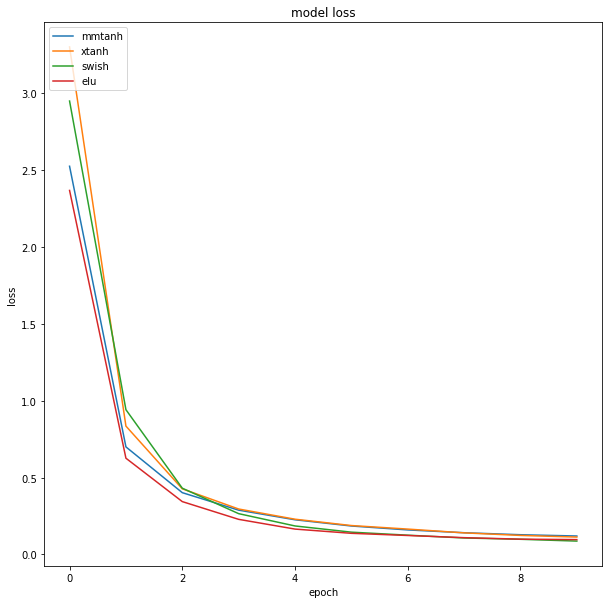

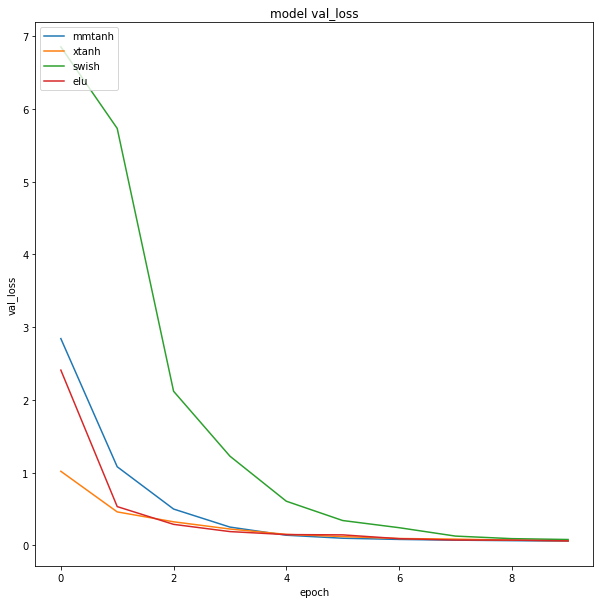

In [32]:
plot_histories(histories)

In [8]:
nets_mmtanh={}
for s in np.arange(0.1,1.0,0.1):
    nets_mmtanh[s]={}
    print(s,":", end='')
    for a in np.arange(0.1,1.0,0.1):
        print(a,"," end='')
        activation=build_mmtanh(s,a)
        nets_mmtanh[s][a]=create_base_network(input_shape,activation)
    print()

0.1 :0.10.20.300000000000000040.40.50.60.70000000000000010.80.9
0.2 :0.10.20.300000000000000040.40.50.60.70000000000000010.80.9
0.30000000000000004 :0.10.20.300000000000000040.40.50.60.70000000000000010.80.9
0.4 :0.10.20.300000000000000040.40.50.60.70000000000000010.80.9
0.5 :0.10.20.300000000000000040.40.50.60.70000000000000010.80.9
0.6 :0.10.20.300000000000000040.40.50.60.70000000000000010.80.9
0.7000000000000001 :0.10.20.300000000000000040.40.50.60.70000000000000010.80.9
0.8 :0.10.20.300000000000000040.40.50.60.70000000000000010.80.9
0.9 :0.10.20.300000000000000040.40.50.60.70000000000000010.80.9


In [34]:
my_cnn_mmtanh=create_base_network(input_shape,mmtanh)
my_cnn_mmtanh.summary()
my_cnn_mmtanh.compile(loss=losses.categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['accuracy'])

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
activation_40 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
activation_41 (Activation)   (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 6, 6, 64)          0  

In [ ]:
epochs=10
batch_size=1000
history_mmtanh=my_cnn_mmtanh.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


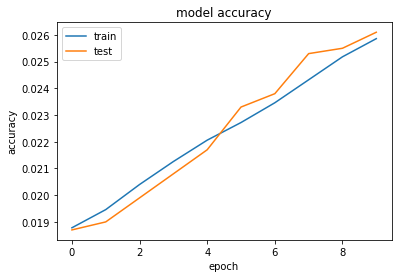

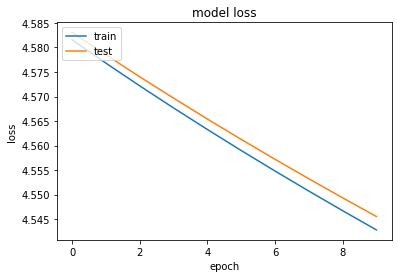

In [48]:
print(history_mmtanh.history.keys())
plot_history(history_mmtanh)

In [36]:
my_cnn_relu=create_base_network(input_shape,tf.nn.relu)
my_cnn_relu.compile(loss=losses.categorical_crossentropy,
            optimizer=Adadelta(),
            metrics=['accuracy'])

In [37]:
epochs=10
batch_size=1000
my_cnn_relu.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s 33us/sample - loss: 4.6101 - accuracy: 0.0078 - val_loss: 4.6102 - val_accuracy: 0.0061
Epoch 2/10
50000/50000 [==============================] - 1s 27us/sample - loss: 4.6097 - accuracy: 0.0079 - val_loss: 4.6097 - val_accuracy: 0.0063
Epoch 3/10
50000/50000 [==============================] - 1s 27us/sample - loss: 4.6092 - accuracy: 0.0081 - val_loss: 4.6093 - val_accuracy: 0.0067
Epoch 4/10
50000/50000 [==============================] - 1s 27us/sample - loss: 4.6088 - accuracy: 0.0083 - val_loss: 4.6089 - val_accuracy: 0.0067
Epoch 5/10
50000/50000 [==============================] - 1s 28us/sample - loss: 4.6084 - accuracy: 0.0084 - val_loss: 4.6085 - val_accuracy: 0.0064
Epoch 6/10
50000/50000 [==============================] - 1s 28us/sample - loss: 4.6080 - accuracy: 0.0086 - val_loss: 4.6081 - val_accuracy: 0.0065
Epoch 7/10
50000/50000 [==============================] 

In [38]:
my_cnn_swish=create_base_network(input_shape,swish)
my_cnn_swish.compile(loss=losses.categorical_crossentropy,
            optimizer=Adadelta(),
            metrics=['accuracy'])

In [39]:
epochs=10
batch_size=1000
my_cnn_swish.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s 44us/sample - loss: 4.6055 - accuracy: 0.0096 - val_loss: 4.6055 - val_accuracy: 0.0103
Epoch 2/10
50000/50000 [==============================] - 2s 37us/sample - loss: 4.6054 - accuracy: 0.0096 - val_loss: 4.6055 - val_accuracy: 0.0102
Epoch 3/10
50000/50000 [==============================] - 2s 37us/sample - loss: 4.6054 - accuracy: 0.0097 - val_loss: 4.6054 - val_accuracy: 0.0102
Epoch 4/10
50000/50000 [==============================] - 2s 37us/sample - loss: 4.6053 - accuracy: 0.0097 - val_loss: 4.6054 - val_accuracy: 0.0102
Epoch 5/10
50000/50000 [==============================] - 2s 38us/sample - loss: 4.6053 - accuracy: 0.0097 - val_loss: 4.6054 - val_accuracy: 0.0100
Epoch 6/10
50000/50000 [==============================] - 2s 38us/sample - loss: 4.6053 - accuracy: 0.0097 - val_loss: 4.6053 - val_accuracy: 0.0101
Epoch 7/10
50000/50000 [==============================] 

In [40]:
my_cnn_xtanh=create_base_network(input_shape,xtanh)
my_cnn_xtanh.compile(loss=losses.categorical_crossentropy,
            optimizer=Adadelta(),
            metrics=['accuracy'])

In [41]:
epochs=10
batch_size=1000
my_cnn_xtanh.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 2s 45us/sample - loss: 4.6528 - accuracy: 0.0102 - val_loss: 4.6533 - val_accuracy: 0.0123
Epoch 2/10
50000/50000 [==============================] - 2s 36us/sample - loss: 4.6454 - accuracy: 0.0106 - val_loss: 4.6460 - val_accuracy: 0.0124
Epoch 3/10
50000/50000 [==============================] - 2s 36us/sample - loss: 4.6382 - accuracy: 0.0111 - val_loss: 4.6390 - val_accuracy: 0.0128
Epoch 4/10
50000/50000 [==============================] - 2s 37us/sample - loss: 4.6312 - accuracy: 0.0115 - val_loss: 4.6321 - val_accuracy: 0.0132
Epoch 5/10
50000/50000 [==============================] - 2s 36us/sample - loss: 4.6245 - accuracy: 0.0121 - val_loss: 4.6256 - val_accuracy: 0.0132
Epoch 6/10
50000/50000 [==============================] - 2s 37us/sample - loss: 4.6179 - accuracy: 0.0123 - val_loss: 4.6192 - val_accuracy: 0.0143
Epoch 7/10
50000/50000 [==============================] 